# Going deeper with Tensorflow

In this video, we're going to study the tools you'll use to build deep learning models. Namely, [Tensorflow](https://www.tensorflow.org/).

If you're running this notebook outside the course environment, you'll need to install tensorflow:
* `pip install tensorflow` should install cpu-only TF on Linux & Mac OS
* If you want GPU support from offset, see [TF install page](https://www.tensorflow.org/install/)

In [1]:
import sys
sys.path.append("..")
import grading

# Visualization

Plase note that if you are running on the Coursera platform, you won't be able to access the tensorboard instance due to the network setup there. If you run the notebook locally, you should be able to access TensorBoard on http://127.0.0.1:7007/

In [2]:
! killall tensorboard
import os
os.system("tensorboard --logdir=/tmp/tboard --port=7007 &");

/bin/sh: 1: killall: not found


In [3]:
import tensorflow as tf
s = tf.InteractiveSession()

# Warming up
For starters, let's implement a python function that computes the sum of squares of numbers from 0 to N-1.

In [4]:
import numpy as np
def sum_sin(N):
    return np.sum(np.arange(N)**2)

In [5]:
%%time
sum_sin(10**8)

CPU times: user 180 ms, sys: 2.41 s, total: 2.59 s
Wall time: 3.86 s


662921401752298880

# Tensoflow teaser

Doing the very same thing

In [6]:
# An integer parameter
N = tf.placeholder('int64', name="input_to_your_function")

# A recipe on how to produce the same result
result = tf.reduce_sum(tf.range(N)**2)

In [7]:
result

<tf.Tensor 'Sum:0' shape=() dtype=int64>

In [8]:
%%time
result.eval({N: 10**8})

CPU times: user 436 ms, sys: 928 ms, total: 1.36 s
Wall time: 1.57 s


662921401752298880

In [9]:
writer = tf.summary.FileWriter("/tmp/tboard", graph=s.graph)

# How does it work?
1. Define placeholders where you'll send inputs
2. Make symbolic graph: a recipe for mathematical transformation of those placeholders
3. Compute outputs of your graph with particular values for each placeholder
  * `output.eval({placeholder:value})`
  * `s.run(output, {placeholder:value})`

So far there are two main entities: "placeholder" and "transformation"
* Both can be numbers, vectors, matrices, tensors, etc.
* Both can be int32/64, floats, booleans (uint8) of various size.

* You can define new transformations as an arbitrary operation on placeholders and other transformations
 * `tf.reduce_sum(tf.arange(N)**2)` are 3 sequential transformations of placeholder `N`
 * There's a tensorflow symbolic version for every numpy function
   * `a+b, a/b, a**b, ...` behave just like in numpy
   * `np.mean` -> `tf.reduce_mean`
   * `np.arange` -> `tf.range`
   * `np.cumsum` -> `tf.cumsum`
   * If if you can't find the op you need, see the [docs](https://www.tensorflow.org/api_docs/python).
   
`tf.contrib` has many high-level features, may be worth a look.

In [10]:
with tf.name_scope("Placeholders_examples"):
    # Default placeholder that can be arbitrary float32
    # scalar, vertor, matrix, etc.
    arbitrary_input = tf.placeholder('float32')

    # Input vector of arbitrary length
    input_vector = tf.placeholder('float32', shape=(None,))

    # Input vector that _must_ have 10 elements and integer type
    fixed_vector = tf.placeholder('int32', shape=(10,))

    # Matrix of arbitrary n_rows and 15 columns
    # (e.g. a minibatch your data table)
    input_matrix = tf.placeholder('float32', shape=(None, 15))
    
    # You can generally use None whenever you don't need a specific shape
    input1 = tf.placeholder('float64', shape=(None, 100, None))
    input2 = tf.placeholder('int32', shape=(None, None, 3, 224, 224))

    # elementwise multiplication
    double_the_vector = input_vector*2

    # elementwise cosine
    elementwise_cosine = tf.cos(input_vector)

    # difference between squared vector and vector itself plus one
    vector_squares = input_vector**2 - input_vector + 1

In [11]:
my_vector =  tf.placeholder('float32', shape=(None,), name="VECTOR_1")
my_vector2 = tf.placeholder('float32', shape=(None,))
my_transformation = my_vector * my_vector2 / (tf.sin(my_vector) + 1)

In [12]:
print(my_transformation)

Tensor("truediv:0", shape=(?,), dtype=float32)


In [13]:
dummy = np.arange(5).astype('float32')
print(dummy)
my_transformation.eval({my_vector:dummy, my_vector2:dummy[::-1]})

[ 0.  1.  2.  3.  4.]


array([ 0.        ,  1.62913239,  2.09501147,  2.62899613,  0.        ], dtype=float32)

In [14]:
writer.add_graph(my_transformation.graph)
writer.flush()

TensorBoard allows writing scalars, images, audio, histogram. You can read more on tensorboard usage [here](https://www.tensorflow.org/get_started/graph_viz).

# Summary
* Tensorflow is based on computation graphs
* The graphs consist of placehlders and transformations

# Mean squared error

Your assignment is to implement mean squared error in tensorflow.

In [15]:
with tf.name_scope("MSE"):
    y_true = tf.placeholder("float32", shape=(None,), name="y_true")
    y_predicted = tf.placeholder("float32", shape=(None,), name="y_predicted")
    # Your code goes here
    # You want to use tf.reduce_mean
    mse = tf.reduce_mean((y_true - y_predicted)**2)
def compute_mse(vector1, vector2):
    return mse.eval({y_true: vector1, y_predicted: vector2})

In [16]:
writer.add_graph(mse.graph)
writer.flush()

Tests and result submission. Please use the credentials obtained from the Coursera assignment page.

In [17]:
import submit

In [18]:
submit.submit_mse(compute_mse, 'VENHEADs@yandex.ru', 'xsnlHU1LJCjQFp1h')

Submitted to Coursera platform. See results on assignment page!


# Variables

The inputs and transformations have no value outside function call. This isn't too comfortable if you want your model to have parameters (e.g. network weights) that are always present, but can change their value over time.

Tensorflow solves this with `tf.Variable` objects.
* You can assign variable a value at any time in your graph
* Unlike placeholders, there's no need to explicitly pass values to variables when `s.run(...)`-ing
* You can use variables the same way you use transformations 
 

In [20]:
# Initialize variable(s) with initial values
s.run(tf.global_variables_initializer())

# Evaluating shared variable (outside symbolicd graph)
print("Initial value", s.run(shared_vector_1))

# Within symbolic graph you use them just
# as any other inout or transformation, not "get value" needed

Initial value [ 1.  1.  1.  1.  1.]


In [21]:
# Setting a new value
s.run(shared_vector_1.assign(np.arange(5)))

# Getting that new value
print("New value", s.run(shared_vector_1))

New value [ 0.  1.  2.  3.  4.]


# tf.gradients - why graphs matter
* Tensorflow can compute derivatives and gradients automatically using the computation graph
* True to its name it can manage matrix derivatives
* Gradients are computed as a product of elementary derivatives via the chain rule:

$$ {\partial f(g(x)) \over \partial x} = {\partial f(g(x)) \over \partial g(x)}\cdot {\partial g(x) \over \partial x} $$

It can get you the derivative of any graph as long as it knows how to differentiate elementary operations

In [22]:
my_scalar = tf.placeholder('float32')

scalar_squared = my_scalar**3
x = np.linspace(-3, 3)

# A derivative of scalar_squared by my_scalar
derivative = tf.gradients(scalar_squared, [my_scalar,])
derivative_1 = tf.gradients(derivative, [my_scalar,])
s.run([derivative_1[0]],
                                 {my_scalar:x})

[array([-18.        , -17.26530647, -16.53061295, -15.79591751,
        -15.06122398, -14.32653046, -13.59183693, -12.85714245,
        -12.12244892, -11.38775539, -10.65306091,  -9.91836739,
         -9.18367386,  -8.44898033,  -7.71428585,  -6.97959232,
         -6.24489784,  -5.51020384,  -4.77550983,  -4.04081631,
         -3.3061223 ,  -2.57142854,  -1.83673477,  -1.10204077,
         -0.36734694,   0.36734694,   1.10204077,   1.83673477,
          2.57142854,   3.3061223 ,   4.04081631,   4.77550983,
          5.51020384,   6.24489784,   6.97959232,   7.71428585,
          8.44898033,   9.18367386,   9.91836739,  10.65306091,
         11.38775539,  12.12244892,  12.85714245,  13.59183693,
         14.32653046,  15.06122398,  15.79591751,  16.53061295,
         17.26530647,  18.        ], dtype=float32)]

In [23]:
scalar_squared = my_scalar**2
derivative = tf.gradients(scalar_squared, [my_scalar,])
s.run([derivative[0]],
                                 {my_scalar:x})

[array([-6.        , -5.75510216, -5.51020432, -5.265306  , -5.02040815,
        -4.77551031, -4.53061247, -4.28571415, -4.04081631, -3.79591846,
        -3.55102038, -3.30612254, -3.06122446, -2.81632662, -2.57142854,
        -2.32653069, -2.08163261, -1.83673465, -1.59183669, -1.34693873,
        -1.10204077, -0.85714287, -0.6122449 , -0.36734694, -0.12244898,
         0.12244898,  0.36734694,  0.6122449 ,  0.85714287,  1.10204077,
         1.34693873,  1.59183669,  1.83673465,  2.08163261,  2.32653069,
         2.57142854,  2.81632662,  3.06122446,  3.30612254,  3.55102038,
         3.79591846,  4.04081631,  4.28571415,  4.53061247,  4.77551031,
         5.02040815,  5.265306  ,  5.51020432,  5.75510216,  6.        ], dtype=float32)]

In [24]:
derivative

[<tf.Tensor 'gradients_2/pow_2_grad/Reshape:0' shape=<unknown> dtype=float32>]

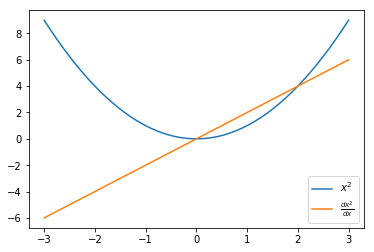

In [25]:
import matplotlib.pyplot as plt
%matplotlib inline

x = np.linspace(-3, 3)
x_squared, x_squared_der = s.run([scalar_squared, derivative[0]],
                                 {my_scalar:x})

plt.plot(x, x_squared,label="$x^2$")
plt.plot(x, x_squared_der, label=r"$\frac{dx^2}{dx}$")
plt.legend();

# Why that rocks

In [26]:
my_vector = tf.placeholder('float32', [None])
# Compute the gradient of the next weird function over my_scalar and my_vector
# Warning! Trying to understand the meaning of that function may result in permanent brain damage
weird_psychotic_function = tf.reduce_mean(
    (my_vector+my_scalar)**(1+tf.nn.moments(my_vector,[0])[1]) + 
    1./ tf.atan(my_scalar))/(my_scalar**2 + 1) + 0.01*tf.sin(
    2*my_scalar**1.5)*(tf.reduce_sum(my_vector)* my_scalar**2
                      )*tf.exp((my_scalar-4)**2)/(
    1+tf.exp((my_scalar-4)**2))*(1.-(tf.exp(-(my_scalar-4)**2)
                                    )/(1+tf.exp(-(my_scalar-4)**2)))**2

der_by_scalar = tf.gradients(weird_psychotic_function, my_scalar)
der_by_vector = tf.gradients(weird_psychotic_function, my_vector)

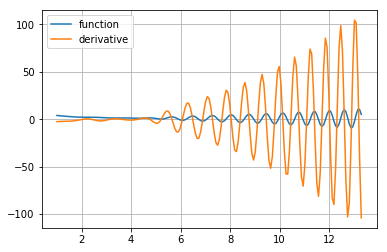

In [27]:
# Plotting the derivative
scalar_space = np.linspace(1, 70, 1000)

y = [s.run(weird_psychotic_function, {my_scalar:x, my_vector:[1, 2, 3]})
     for x in scalar_space]

plt.plot(scalar_space, y, label='function')

y_der_by_scalar = [s.run(der_by_scalar,
                         {my_scalar:x, my_vector:[1, 2, 3]})
                   for x in scalar_space]

plt.plot(scalar_space, y_der_by_scalar, label='derivative')
plt.grid()
plt.legend();

# Almost done - optimizers

While you can perform gradient descent by hand with automatic grads from above, tensorflow also has some optimization methods implemented for you. Recall momentum & rmsprop?

In [73]:
y_guess = tf.Variable(np.zeros(2, dtype='float32'))
y_true = tf.range(1, 3, dtype='float32')
loss = tf.reduce_mean((y_guess - y_true + tf.random_normal([2]))**2) 
#loss = tf.reduce_mean((y_guess - y_true)**2) 
optimizer = tf.train.MomentumOptimizer(0.01, 0.5).minimize(
    loss, var_list=y_guess)

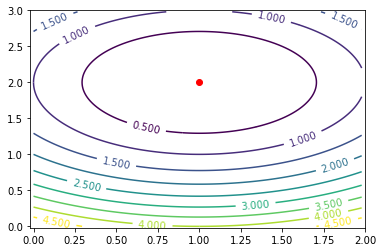

In [74]:
from matplotlib import animation, rc
import matplotlib_utils
from IPython.display import HTML, display_html

fig, ax = plt.subplots()
y_true_value = s.run(y_true)
level_x = np.arange(0, 2, 0.02)
level_y = np.arange(0, 3, 0.02)
X, Y = np.meshgrid(level_x, level_y)
Z = (X - y_true_value[0])**2 + (Y - y_true_value[1])**2
ax.set_xlim(-0.02, 2)
ax.set_ylim(-0.02, 3)
s.run(tf.global_variables_initializer())
ax.scatter(*s.run(y_true), c='red')
contour = ax.contour(X, Y, Z, 10)
ax.clabel(contour, inline=1, fontsize=10)
line, = ax.plot([], [], lw=2)

def init():
    line.set_data([], [])
    return (line,)

guesses = [s.run(y_guess)]

def animate(i):
    s.run(optimizer)
    guesses.append(s.run(y_guess))
    line.set_data(*zip(*guesses))
    return (line,)

anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=400, interval=20, blit=True)

In [75]:
try:
    display_html(HTML(anim.to_html5_video()))
# In case the build-in renderers are unaviable, fall back to
# a custom one, that doesn't require external libraries
except RuntimeError:
    anim.save(None, writer=matplotlib_utils.SimpleMovieWriter(0.001))

<img src="%2BTl5ufo6erx8vP09fb3%2BPn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6goOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4uPk5ebn6Onq8vP09fb3%2BPn6/9oADAMBAAIRAxEAPwD9/KKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAorj/AAR%2B0J8A/iZ431n4Z/Dj44eD/EHiTw5JJH4h8P6J4ltbu%2B0t0kMTrcQRSNJAVkBQh1GGG088VZtfjb8Gb74p3PwLsvi54Ym8b2dgL288HRa/btqsFqQpE72gfzljIdPnK7fmXnkUAdPRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAfIz%2BIrvxH/wUT0j40aVp3xZ1nw/4Z8I6/pWr2XiP4WX%2Bn6b4Ukmn0yMNpUo06CbVWu5bUtJiS%2BRUQyxvbxjbLy/g74f/EGL9qTw98N5fhR4oh17Qf2nfEnj3WvGcvhq6TSpvDt5oWp29tImpmP7NPIVvbDT/sqyGZPszMYxHCr19w0UAeIftr%2BO/wBp34WeFtF8bfAPx94D022ufF/hzw/qFj4v8B3uqyO%2Bq67Y6X9ojlttVsxGIkvDJ5ZR95jA3oDkWf8AhB/%2BChf/AEdB8Gf/AAw%2Brf8AzUUft4f8kQ0P/ss3w4/9TXRK9moA8Z/4Qf8A4KF/9HQfBn/ww%2Brf/NRVbWdA/bz8OaRdeIPEP7W3wQsLCyt3nvb29%2BB2qRQ28SAs0ju3ikKigAkkkAAZrtvhz8ddL%2BIPxC8S/DO58F65oGp%2BHTHIkWuxQx/2nZvJNEt5biOVy0JlglTLBW4UlQHUnwnxj4Y%2BMnh7SfE/w8%2BNujX%2BsaZ8RPFEvhqz8ZS%2BM3nuFS8eQ2EkOlRwrDawQsyQuY2EpCNOwKqSOulhHOfLN2emnVp9tbOyu/6dsZ1Uo3Svv/X3lHxB8b/27NYt/Cy/AD9pj4A%2BOLnxXqV3bWWPhRqtnboLWBp58y/8JHKfNCqAsRUFtwJKoC47H4Paz%2B3j8Zfh1p3xD0P9pT4RWkd4JYrqwvPgJqyz2V1DK8FxbSj/AISjiSKaOSNscbkOOKzfC3wc%2BK/xk%2BI914s8Z%2BCNU8Aatplhpl2de32sscviW1M0TXVtHHI3m272k8sT7wm%2BO5ZPvLlPb/gn8K5vhL4RuNG1LxGNX1PUtYvNV1nU0sVtUuLu5lMkjJCpYRoMgBdzHC5LMSSdcTTwtKlyxfvffvfqtNrbWflrpNKVWUrvb%2BvmeEeBx/wWR8RfFHWNF8XeKPgJ4e8H2FxPDpniCf4dapc32qbWxHMlnF4gKRRuAW/eThxkZTOcegf8IP8A8FC/%2BjoPgz/4YfVv/mor2aiuKclN3UUvS/6tm0U0tXc8Z/4Qf/goX/0dB8Gf/DD6t/8ANRR/wg//AAUL/wCjoPgz/wCGH1b/AOaivZqw/iF8T/ht8JPDsni/4qfEDRPDWlQ/63Ute1SGzgXjODJKyrn8amMZSdoq7K3PNf8AhB/%2BChf/AEdB8Gf/AAw%2Brf8AzUUf8IP/AMFC/wDo6D4M/wDhh9W/%2BaiuQn/4Kh/BjxncPpn7Lfwu%2BInxlulcx/afAPhOX%2BzEkzgB9SvDBaBf9pZH78HFNHiv/gqv8XOfD3wo%2BFXwe0%2BX5Wl8V65ceJtVjH98QWQgtVb2M7jPr1rs/s/ER/i2h/iaT%2B7WX/kpfJLrodj/AMIP/wAFC/8Ao6D4M/8Ahh9W/wDmorK8XH9tXwBpZ1vx5%2B2j8BNEsl%2B9eav8F9Stoh/wOTxUB%2BtYn/DB3xr%2BIH779or/AIKJfFfXc8PpvgZ7TwnYsvdStjGbgj63BODyTWt4R/4JZ/sB%2BE9UGv3H7NOh%2BItT6vqnjiWfX7h267i%2BoyTHOeeMY7Yo9lgYfHVcv8Mf1k1%2BQWgup4x4q/4KMP4T1I6Kf%2BCo37O2tXwyBZeD/gRrmuzE%2BgTTvEs5J7YxWb/w3d%2B3rr//ACSnwjrXi1H/AOPe8tP2O9a022l9CJdT8W2w2%2B/P0r7m8K%2BCvBvgTTRovgjwlpmjWa/dtNKsI7eIf8BjUD9K06Pa4CPw0pP1lb8Ix/ULw7HwPH8av%2BDgjxA4bwj%2BzN8I7OBz8k3jHRfsJx6lLTxNeMv0IzXffCy1/wCC7ev%2BI7T/AIW94p/ZT8N6I%2B77ZLo/hPxHqd9F8jbdsTalBE3z7QcyjAJPJAB%2BuqKieIpSjaNKK/8AAm/xl%2BgnJdjxn/hB/wDgoX/0dB8Gf/DD6t/81FH/AAg//BQv/o6D4M/%2BGH1b/wCaivZqK5STxn/hB/8AgoX/ANHQfBn/AMMPq3/zUUf8IP8A8FC/%2BjoPgz/4YfVv/mor2aigDxn/AIQf/goX/wBHQfBn/wAMPq3/AM1FH/CD/wDBQv8A6Og%2BDP8A4YfVv/mor2aigDxn/hB/%2BChf/R0HwZ/8MPq3/wA1FH/CD/8ABQvt%2B1B8Gf8Aww%2Brf/NRXs1FAHxJ4k1P/g4i8P7pdK0j9kfX0H3E0%2Bw8RW8jD3E96qg/8CNYI/aJ/wCC63hg%2Bd8Sv2XvBot1/wBZP4J8CQ6wf%2BAxyeMLaRv%2B%2BRX3zRXZHE0bWlRi/wDwJflJ/kVzLsfK/wCz98Sv%2BChPx%2B0zUr9/GnhvwRNpk8cU1j8Qf2YtX06WYspO6EjxY6TKMYLIxAJA71pfEvxF/wAFBvh74t8EeC7f9oL4M6he%2BNvEj6Xbr/wpTVYRaxRWNzeTXJ/4qZt4VLbbs%2BXLSKNwr6Wrzbx/%2BzPoHjv4y6D8dU%2BI/jDSdb8O288NhbafrKyaeVmiaKQtZ3EcsIYqeXRVf5R83XMU5Yd13Jq0bOy1lrZ27PfW/QFy3PBf2g/jh/wUO%2BCWpXmmaH8V/hH4kfQPDMniXxhJD8GdStk0nR42kDT5fxOTNKfJmKQqAWELfMOM60Hxz/aoufinb/CGL9rP4VnUrm7SyS7/AOGbde%2BwrfvaC8Wxa6/4SXyluTbETeUWB2%2B4xXb/ABj/AGSvHXxJ8U31xpHxXtLTR/Fvh6w0bx8l1ope9u7e1mkk3WsiSpHCZlkeGRWjZQrFkw2c8PqP7PH7SK6v4g8LaD4b06z0/TfFeu%2BL9B8S/wBqKf7Sv5bcppVsIBmSLySyrK78MLddmRIQnXTo4GpSScrO3e333XR9F038qSg0dT4Q179rv4gavqvh/wACftzfs%2Ba1qGhXAg1ux0r4O6hcTafISQEnRPFZaIkq2AwGcH0rf/4Qf/goX/0dB8Gf/DD6t/8ANRXF/sZeCtWfxvoXiLRPBHiDw54Z8GfCDTvCaQeJdBm0271HUzMJrl3imVXkEIiTE2NjyXc5RnBLH0f4l/ttfsqfBj4q2/wW%2BMHxs0fwr4gu7OO5s4vEbPZW1wjlgoS7mVbdnypygk3jIyBuGeethJKu6dFOVlfRXfntfyfW1yXHWyMz/hB

# Logistic regression
Your assignment is to implement the logistic regression

Plan:
* Use a shared variable for weights
* Use a matrix placeholder for `X`
 
We shall train on a two-class MNIST dataset
* please note that target `y` are `{0,1}` and not `{-1,1}` as in some formulae

In [76]:
from sklearn.datasets import load_digits
mnist = load_digits(2)

X, y = mnist.data, mnist.target

print("y [shape - %s]:" % (str(y.shape)), y[:10])
print("X [shape - %s]:" % (str(X.shape)))

y [shape - (360,)]: [0 1 0 1 0 1 0 0 1 1]
X [shape - (360, 64)]:


X:
 [[  0.   0.   5.  13.   9.   1.   0.   0.   0.   0.]
 [  0.   0.   0.  12.  13.   5.   0.   0.   0.   0.]
 [  0.   0.   1.   9.  15.  11.   0.   0.   0.   0.]]
y:
 [0 1 0 1 0 1 0 0 1 1]


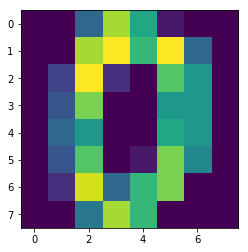

In [77]:
print('X:\n',X[:3,:10])
print('y:\n',y[:10])
plt.imshow(X[0].reshape([8,8]));

It's your turn now!
Just a small reminder of the relevant math:

$$
P(y=1|X) = \sigma(X \cdot W + b)
$$
$$
\text{loss} = -\log\left(P\left(y_\text{predicted} = 1\right)\right)\cdot y_\text{true} - \log\left(1 - P\left(y_\text{predicted} = 1\right)\right)\cdot\left(1 - y_\text{true}\right)
$$

$\sigma(x)$ is available via `tf.nn.sigmoid` and matrix multiplication via `tf.matmul`

In [296]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, random_state=42)

__Your code goes here.__ For the training and testing scaffolding to work, please stick to the names in comments.

In [339]:
# Model parameters - weights and bias
weights = tf.Variable(initial_value= tf.zeros((X.shape[1],1)),name='weights',dtype='float32')# shape should be (X.shape[1], 1)
#b = tf.Variable(initial_value= np.random.random((1)),name='bias',dtype='float32')
b = tf.Variable(1,name='bias',dtype='float32')

In [340]:
# Placeholders for the input data
input_X = tf.placeholder('float32', shape=(None, X_train.shape[1]))
input_y = tf.placeholder('float32', shape=(None,))

In [341]:
predicted_y = tf.matmul(input_X,weights)+b
predicted_y = tf.nn.sigmoid(predicted_y)
predicted_y = tf.squeeze(predicted_y)
loss = tf.reduce_mean(-1*tf.log(predicted_y)*input_y - tf.log(1 - predicted_y)*(1-input_y))
optimizer = tf.train.MomentumOptimizer(0.01, 0.5).minimize(loss)


In [342]:
# The model code

# Compute a vector of predictions, resulting shape should be [input_X.shape[0],]
# This is 1D, if you have extra dimensions, you can  get rid of them with tf.squeeze .
# Don't forget the sigmoid.
# predicted_y = <predicted probabilities for input_X>

# Loss. Should be a scalar number - average loss over all the objects
# tf.reduce_mean is your friend here
# loss = <logistic loss (scalar, mean over sample)>

# See above for an example. tf.train.*Optimizer
# optimizer = <optimizer that minimizes loss>

A test to help with the debugging

In [343]:
assert np.allclose(validation_true_values, prediction_validation)


In [344]:
validation_weights = 1e-3 * np.fromiter(map(lambda x:
        s.run(weird_psychotic_function, {my_scalar:x, my_vector:[1, 0.1, 2]}),
                                   0.15 * np.arange(1, X.shape[1] + 1)),
                                   count=X.shape[1], dtype=np.float32)[:, np.newaxis]
# Compute predictions for given weights and bias
prediction_validation = s.run(
    predicted_y, {
    input_X: X,
    weights: validation_weights,
    b: 1e-1})

# Load the reference values for the predictions
validation_true_values = np.loadtxt("validation_predictons.txt")

assert prediction_validation.shape == (X.shape[0],),\
       "Predictions must be a 1D array with length equal to the number " \
       "of examples in input_X"
assert np.allclose(validation_true_values, prediction_validation)
loss_validation = s.run(
        loss, {
            input_X: X[:100],
            input_y: y[-100:],
            weights: validation_weights+1.21e-3,
            b: -1e-1})
assert np.allclose(loss_validation, 0.728689)

In [345]:
from sklearn.metrics import roc_auc_score
s.run(tf.global_variables_initializer())
for i in range(5):
    s.run(optimizer, {input_X: X_train, input_y: y_train})
    loss_i = s.run(loss, {input_X: X_train, input_y: y_train})
    print("loss at iter %i:%.4f" % (i, loss_i))
    print("train auc:", roc_auc_score(y_train, s.run(predicted_y, {input_X:X_train})))
    print("test auc:", roc_auc_score(y_test, s.run(predicted_y, {input_X:X_test})))

loss at iter 0:1.5850
train auc: 0.998847167325
test auc: 1.0
loss at iter 1:0.3342
train auc: 0.999890206412
test auc: 0.999505928854
loss at iter 2:0.0770
train auc: 0.999945103206
test auc: 1.0
loss at iter 3:0.0158
train auc: 1.0
test auc: 1.0
loss at iter 4:nan
train auc: 1.0
test auc: 1.0


### Coursera submission

In [346]:
grade_submitter = grading.Grader("BJCiiY8sEeeCnhKCj4fcOA")

In [347]:
test_weights = 1e-3 * np.fromiter(map(lambda x:
    s.run(weird_psychotic_function, {my_scalar:x, my_vector:[1, 2, 3]}),
                               0.1 * np.arange(1, X.shape[1] + 1)),
                               count=X.shape[1], dtype=np.float32)[:, np.newaxis]

First, test prediction and loss computation. This part doesn't require a fitted model.

In [348]:
prediction_test = s.run(
    predicted_y, {
    input_X: X,
    weights: test_weights,
    b: 1e-1})

In [349]:
assert prediction_test.shape == (X.shape[0],),\
       "Predictions must be a 1D array with length equal to the number " \
       "of examples in X_test"

In [350]:
grade_submitter.set_answer("0ENlN", prediction_test)

In [351]:
loss_test = s.run(
    loss, {
        input_X: X[:100],
        input_y: y[-100:],
        weights: test_weights+1.21e-3,
        b: -1e-1})
# Yes, the X/y indices mistmach is intentional

In [352]:
grade_submitter.set_answer("mMVpM", loss_test)

In [353]:
grade_submitter.set_answer("D16Rc", roc_auc_score(y_test, s.run(predicted_y, {input_X:X_test})))

Please use the credentials obtained from the Coursera assignment page.

In [354]:
grade_submitter.submit('VENHEADs@yandex.ru','Ql8oMDjpRi9D6k6z')

Submitted to Coursera platform. See results on assignment page!
